In [79]:
import pandas as pd
from numpy import mean
from numpy import std
from matplotlib import pyplot as plt

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

from xgboost import XGBClassifier

import time
import tools
import pickle

In [2]:
def evaluate_model(model, X, y, scoring, cv, n_jobs, n_splits=10, n_repeats=3, random_state=1, error_score='raise'):
    
    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)
    n_scores = cross_val_score(model, X, y, scoring=scoring, cv=cv, n_jobs=n_jobs, error_score=error_score)

    return mean(n_scores), std(n_scores)

def evaluate_model_complex(model, X, y, scoring, cv, n_jobs, n_splits=10, n_repeats=3, random_state=1):
    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)
    scores = cross_val_score(model, X, y, scoring=scoring, cv=cv, n_jobs=n_jobs)

    return scores

In [3]:
try:
    raw = pd.read_csv("W:/Shared With Me/Gibraltar/OTHER/AI Crowd Competition/Data/training.csv")
except:
    raw = pd.read_csv("C:/Users/Dev Work/Documents/aicrowd/insurancepricing/python/training.csv")

In [6]:
data = raw.copy()
data = tools.clean(data)
data = data[data['year'] == 1]

y = [1 if row > 0 else 0 for row in data['claim_amount']]

exclude = ['claim_amount', 'id_policy', 'pol_coverage', 'pol_payd', 'pol_pay_freq', 'pol_usage', 'vh_fuel', 'vh_make_model', 'vh_type', 'drv_sex1', 'drv_drv2', 'drv_age2', 'drv_lic2', 'drv_sex2','year']
x = data[data.columns.difference(exclude)]

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
x_train, x_test, y_train, y_test = train_test_split(x, y)

In [7]:
data[data.columns.difference(exclude)]

,drv_age1,drv_age_lic1,drv_age_lic2,pol_duration,pol_no_claims_discount,pol_sit_duration,population,town_surface_area,vh_age,vh_speed,vh_value,vh_weight
0,35,16,1.0,5,0.332,1,1270,33.1,8.0,174.0,11040.0,1143.0
2,55,35,38.0,2,0.196,1,1020,262.8,8.0,150.0,14159.0,1193.0
13,43,21,24.0,14,0.000,1,250,146.7,12.0,180.0,22057.0,1245.0
18,46,27,28.0,10,0.000,1,20,103.6,17.0,174.0,11040.0,1143.0
25,66,43,39.0,2,0.000,2,1030,40.1,9.0,149.0,17233.0,1012.0
...,...,...,...,...,...,...,...,...,...,...,...,...
57029,46,26,33.0,21,0.000,2,1190,43.0,1.0,170.0,11405.0,1197.0
57030,45,25,24.0,14,0.000,2,310,337.2,14.0,185.0,31856.0,1384.0
57031,36,16,19.0,6,0.000,1,180,263.1,29.0,151.0,10570.0,840.0
57036,57,38,9.0,7,0.000,1,2550,164.2,29.0,170.0,13865.0,961.0


In [37]:
n_trees = [50, 100] #[10,100,1000,5000]
max_depth = [2,4,8] #[x for x in range(1,12,2)]
learning_rate = [0.2, 0.4, 0.6,0.8,1]

In [38]:
'''
Warning, this cell will take a very, very long time to run without a decent PC.

I'd recommend not running on laptops...

'''

trees = {}

names = list()

start = time.time()

for n in n_trees:
    depths = {}
    for i in max_depth:
        results = {}
        for r in learning_rate:
            xg = XGBClassifier(n_estimators=n, max_depth=i, eta=r, eval_metric='logloss')
            xg.fit(x_train, y_train)

            scores = evaluate_model_complex(xg, x_test, y_test, 'accuracy', cv, -1)
            
            results[r] = {"scores":scores, "model":xg}

        depths[i] = results.copy()
    trees[n] = depths.copy()

end = time.time()

print(f"Time Taken: {end-start}")

Time Taken: 33.61375021934509


In [39]:
rows = []

for tree in trees:
    for depth in trees[tree]:
        for rate in trees[tree][depth]:
            rows.append((tree, depth, rate, mean(trees[tree][depth][rate]['scores'])))

graph_data = pd.DataFrame(rows, columns=['trees', 'depth', 'rate', 'mean'])


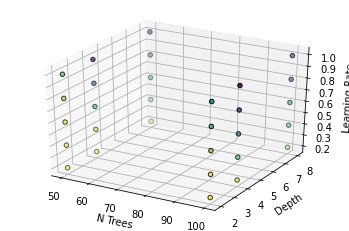

In [40]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.set_zscale='log'
ax.set_xscale='log'
ax.set_xlabel("N Trees")
ax.set_ylabel("Depth")
ax.set_zlabel("Learning Rate")
ax.scatter(graph_data['trees'].astype(float), graph_data['depth'].astype(float), graph_data['rate'].astype(float), c=graph_data['mean'], edgecolors='black')

In [76]:
peak_data = graph_data[graph_data['mean'] == graph_data['mean'].max()]
peak_models = []

for row_tuple in peak_data.iterrows():
    row = row_tuple[1]
    peak_models.append(trees[row['trees']][row['depth']][row['rate']]['model'])

In [80]:
for model in peak_models:
    with open('regression_frequency_model.pickle', 'wb') as target:
        pickle.dump(model, target)